# Лабораторная работа №2

In [30]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
import seaborn as sns
import arviz

sns.set_style("ticks",{'axes.grid' : True})
sns.set_theme(rc={'figure.figsize':(8, 8)})

### Задание 1

Методом максимального правдоподобия найти оценку параметра $\theta$ биномиального распределения $Bin(m, \theta)$, считая $m$ известным. Эксперимент при $m=4$, $\theta=\frac{1}{5}$

Функция вероятности для биномиального распределения имеет вид $P(X=x_j)=C^{x_j}_{m}\theta^{x_j}(1-\theta)^{m-x_j}$. Составим функцию правдоподобия: $L(X|\theta)=\Pi_{j=1}^{n}C^{x_j}_{m}\theta^{x_j}(1-\theta)^{m-x_j} \Rightarrow ln L(X|\theta)=ln(\Pi_{j=1}^{n}C^{x_j}_{m})+\sum_{j=1}^{n}(x_jln\theta + (m-x_j)ln(1-\theta))$

$\frac{d \ ln L(X|\theta)}{d\theta}=\sum_{j=1}^{n}(\frac{x_j}{\theta}-\frac{m-x_j}{1-\theta})=\frac{1}{\theta}\sum_{j=1}^{n}x_j - \frac{1}{1-\theta}(nm-\sum_{j=1}^{n}x_j)$. Обозначим $S_n=\sum_{j=1}^{n}x_j$, тогда $\frac{d \ ln L(X|\theta)}{d\theta}=\frac{S_n}{\theta}-\frac{nm-S_n}{1-\theta}$

Найдем точки экстремума. $\frac{S_n}{\hat\theta}-\frac{nm-S_n}{1-\hat\theta}=0 \Leftrightarrow \frac{S_n}{\hat\theta}=\frac{nm-S_n}{1-\hat\theta} \Leftrightarrow S_n(1-\hat\theta)=\hat\theta(nm-S_n) \Leftrightarrow S_n=\hat\theta \cdot nm \Leftrightarrow \hat\theta = \frac{S_n}{nm}=\frac{\sum_{j=1}^{n}x_j}{nm}=\frac{\overline{X}}{m}$

Функция $\frac{S_n}{\hat\theta}-\frac{nm-S_n}{1-\hat\theta}$ (при $0<\theta<1$) убывает, поэтому $\hat\theta=\frac{\overline{X}}{m}$ - максимум функции правдоподобия, соответственно, это оценка максимального правдоподобия для параметра $\theta$

In [68]:
def plot_theta_extimates(theta_hat, theta, sample_size, interval_type="confidence"):
  theta_mean = theta_hat.mean()
  bias = theta_mean - theta
  variance = theta_hat.var()
  mse = variance + bias ** 2
  if interval_type == "confidence":  # доверительный интервал
    theta_minus = theta_mean - tau * np.sqrt(variance / num_of_samples)
    theta_plus = theta_mean + tau * np.sqrt(variance / num_of_samples)
  elif interval_type == "credible": # достоверный интервал (HDI)
    theta_minus, theta_plus = arviz.hdi(theta_hat, hdi_prob=1 - threshold)
  # print((len(theta_hat[(theta_hat >= theta_minus) & (theta_hat <= theta_plus)])) / len(theta_hat))

  plt.hist(theta_hat, bins=30, alpha=0.6, density=True)
  plt.axvline(theta_minus, color='green', linestyle='dashed', label=r"$(\theta^{-}(X),\theta^{+}(X))$")
  plt.axvline(theta_plus, color='green', linestyle='dashed')
  plt.axvline(theta, color='red', linestyle='dashed', label=r"$\theta$")

  plt.xlabel(r"$\hat\theta$")
  plt.ylabel("frequency")
  plt.title(f'Распределение ОМП при {sample_size=}')
  plt.legend()

  plt.figtext(0.1, 0.01, rf"$bias(\hat\theta)={bias}$", wrap=True, horizontalalignment='left', fontsize=10)
  plt.figtext(0.1, -0.02, rf"$S^2_0(\hat\theta)={variance}$", wrap=True, horizontalalignment='left', fontsize=10)
  plt.figtext(0.1, -0.05, rf"$MSE(\hat\theta)={mse}$", wrap=True, horizontalalignment='left', fontsize=10)
  large_errors = len(theta_hat[abs(theta_hat - theta) / theta >= threshold])
  plt.figtext(0.1, -0.08, f"Количество ОМП " + r"$\frac{|\hat\theta - \theta|}{\theta} >=$" +  rf"${threshold}$" + f" равно {large_errors}",
              wrap=True, horizontalalignment='left', fontsize=10)
  plt.show()


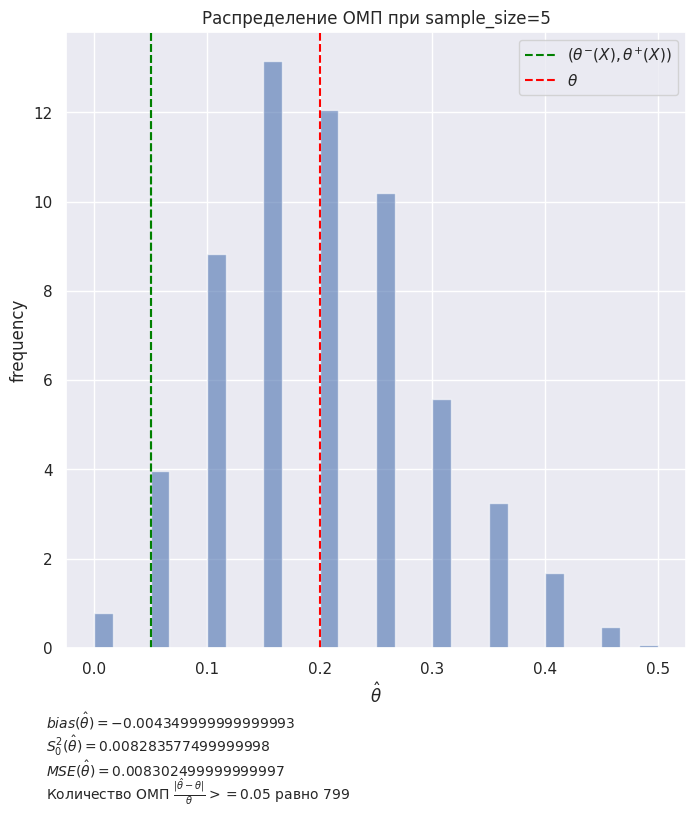

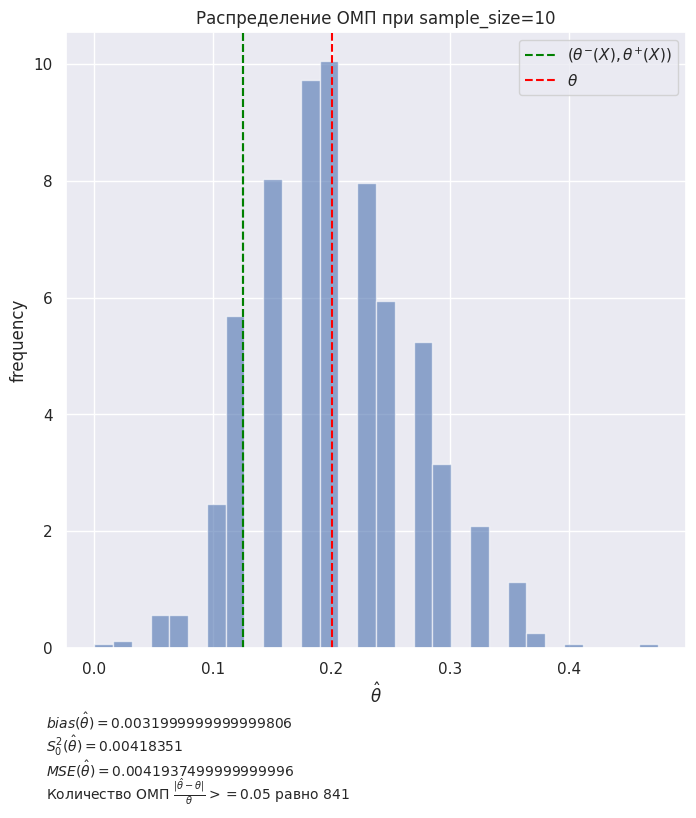

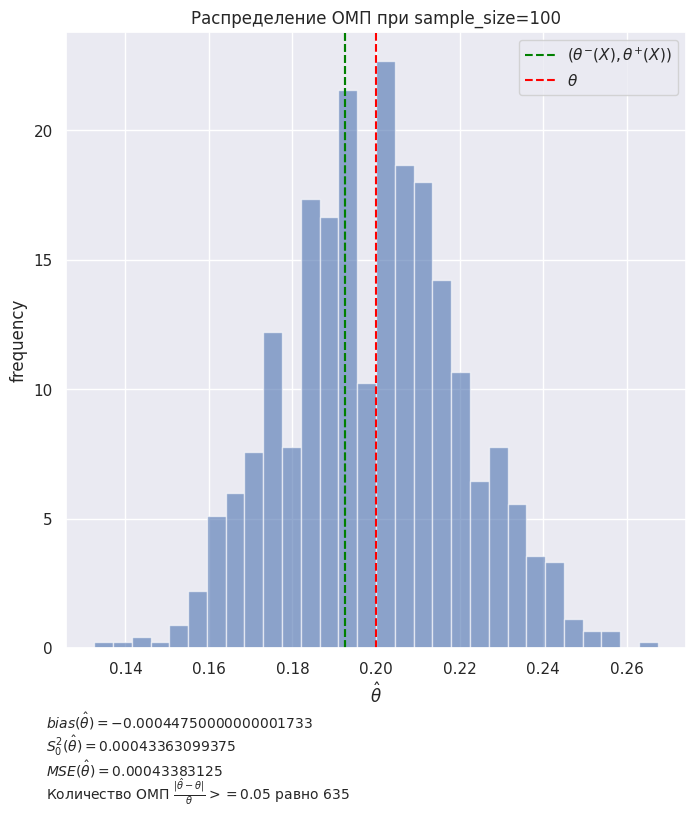

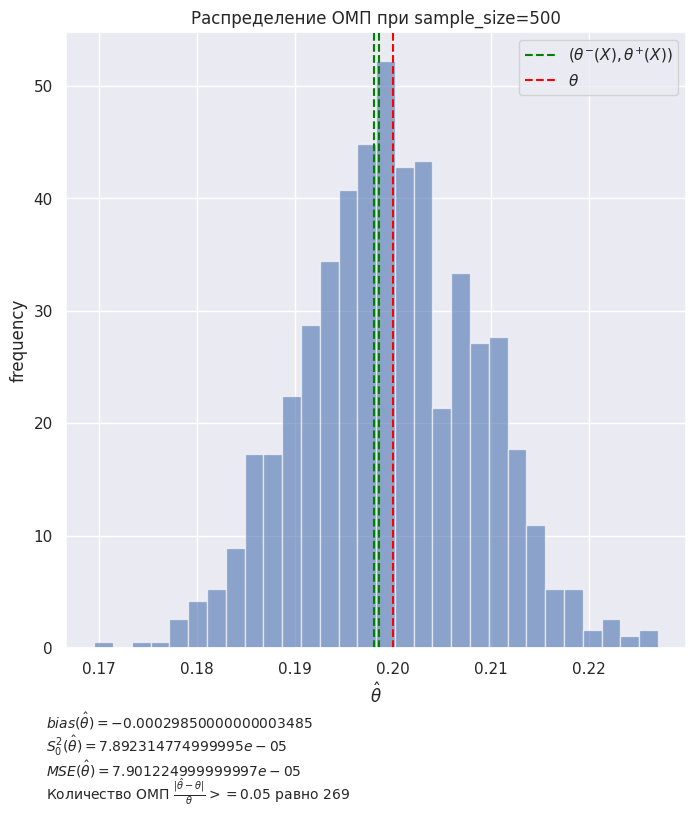

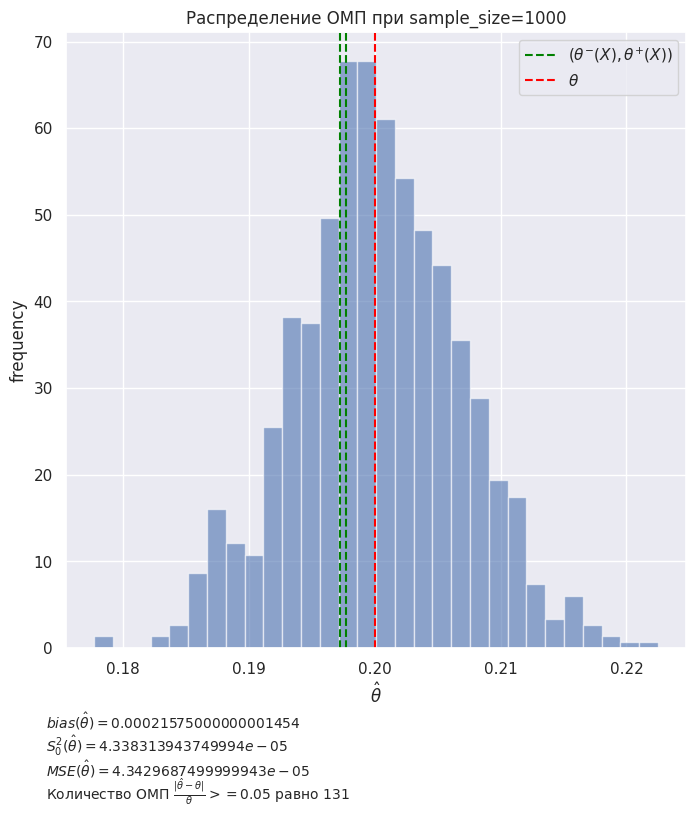

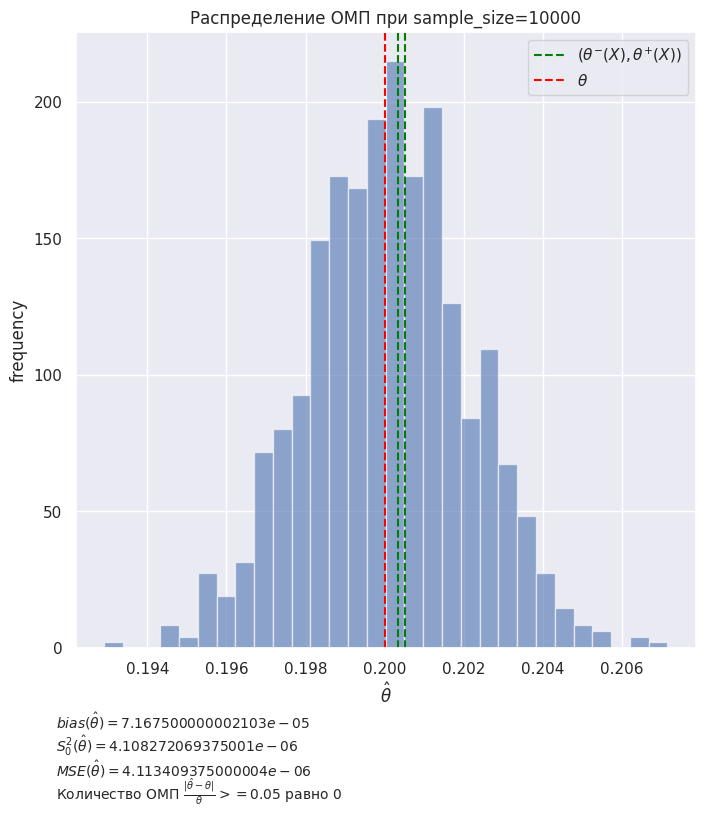

In [ ]:
sample_sizes = [5, 10, 100, 500, 1000, 10000]
num_of_samples = 1000
threshold = 0.05  # уровень значимости
tau = stats.norm.ppf(1 - threshold / 2)

m = 4
theta = 1 / 5
binom = stats.binom(m, theta)


for sample_size in sample_sizes:
  samples = binom.rvs(size=(num_of_samples, sample_size))
  theta_hat = samples.mean(axis=1) / m
  plot_theta_extimates(theta_hat, theta, sample_size, interval_type="confidence")

Проверим асимптотическую нормальность (следовательно, состоятельность) вычисленной оценки

$\sqrt{n}(\hat\theta - \theta) \rightarrow N(0, I^{-1}(\theta))$, где $I(\theta)=-E[\frac{d^2}{d\theta^2}ln \ P(X|\theta)]$ - информация Фишера

$ln \ P(x_j|\theta) = ln(C^{x_j}_{m}) + x_j ln \theta + (m - x_j) (1 - \theta)$

$\frac{d}{d\theta}ln \ P(x_j|\theta) = \frac{x_j}{\theta} - \frac{m-x_j}{1-\theta}$

$\frac{d^2}{d\theta^2}ln \ P(x_j|\theta)=-\frac{x_j}{\theta^2} - \frac{m-x_j}{(1-\theta)^2}$

$I(\theta)=-E[\frac{d^2}{d\theta^2}ln \ P(X|\theta)]=-E[-\frac{X}{\theta^2}-\frac{m-X}{(1-\theta)^2}]=\frac{EX}{\theta^2}+\frac{m-EX}{(1-\theta)^2}=\frac{m\theta}{\theta^2}+\frac{m-m\theta}{(1-\theta)^2}=\frac{m}{\theta}+\frac{m}{1-\theta}=\frac{m}{\theta(1-\theta)}$

Тогда $\sqrt{n}(\hat\theta - \theta) \rightarrow N(0, \frac{\theta(1-\theta)}{m})$

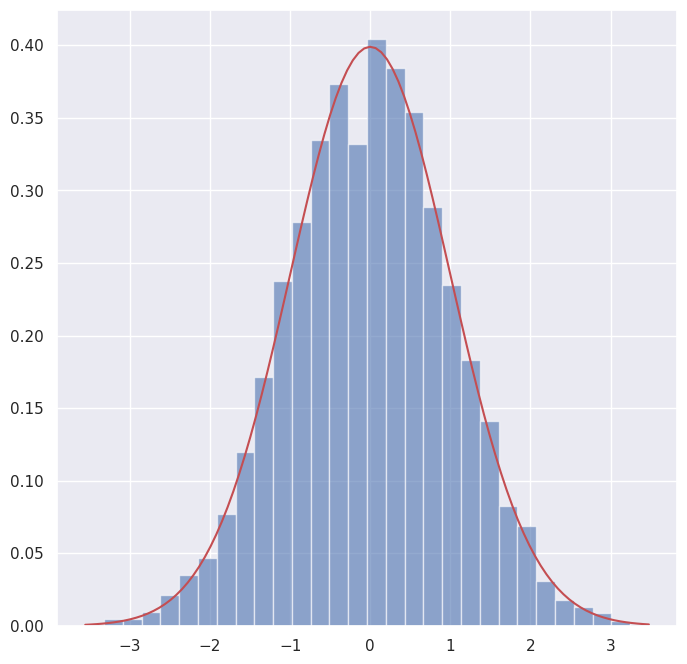

In [65]:
samples = binom.rvs(size=(10000, 1000))
theta_hat = samples.mean(axis=1) / m
asymp_var = np.sqrt(theta * (1 - theta) / m)
standart_theta_hat = np.sqrt(1000) * (theta_hat - theta) / asymp_var

plt.hist(standart_theta_hat, bins=30, alpha=0.6, density=True)

x = np.linspace(min(standart_theta_hat), max(standart_theta_hat), 100)
plt.plot(x, stats.norm.pdf(x, 0, 1), 'r-', label=f"N(0, 1)")
plt.show()


Видно, что при достаточно большом $n$ гистограмма действительно повторяет PDF нормального распределения, оценка $\hat\theta = \frac{\overline{X}}{m}$

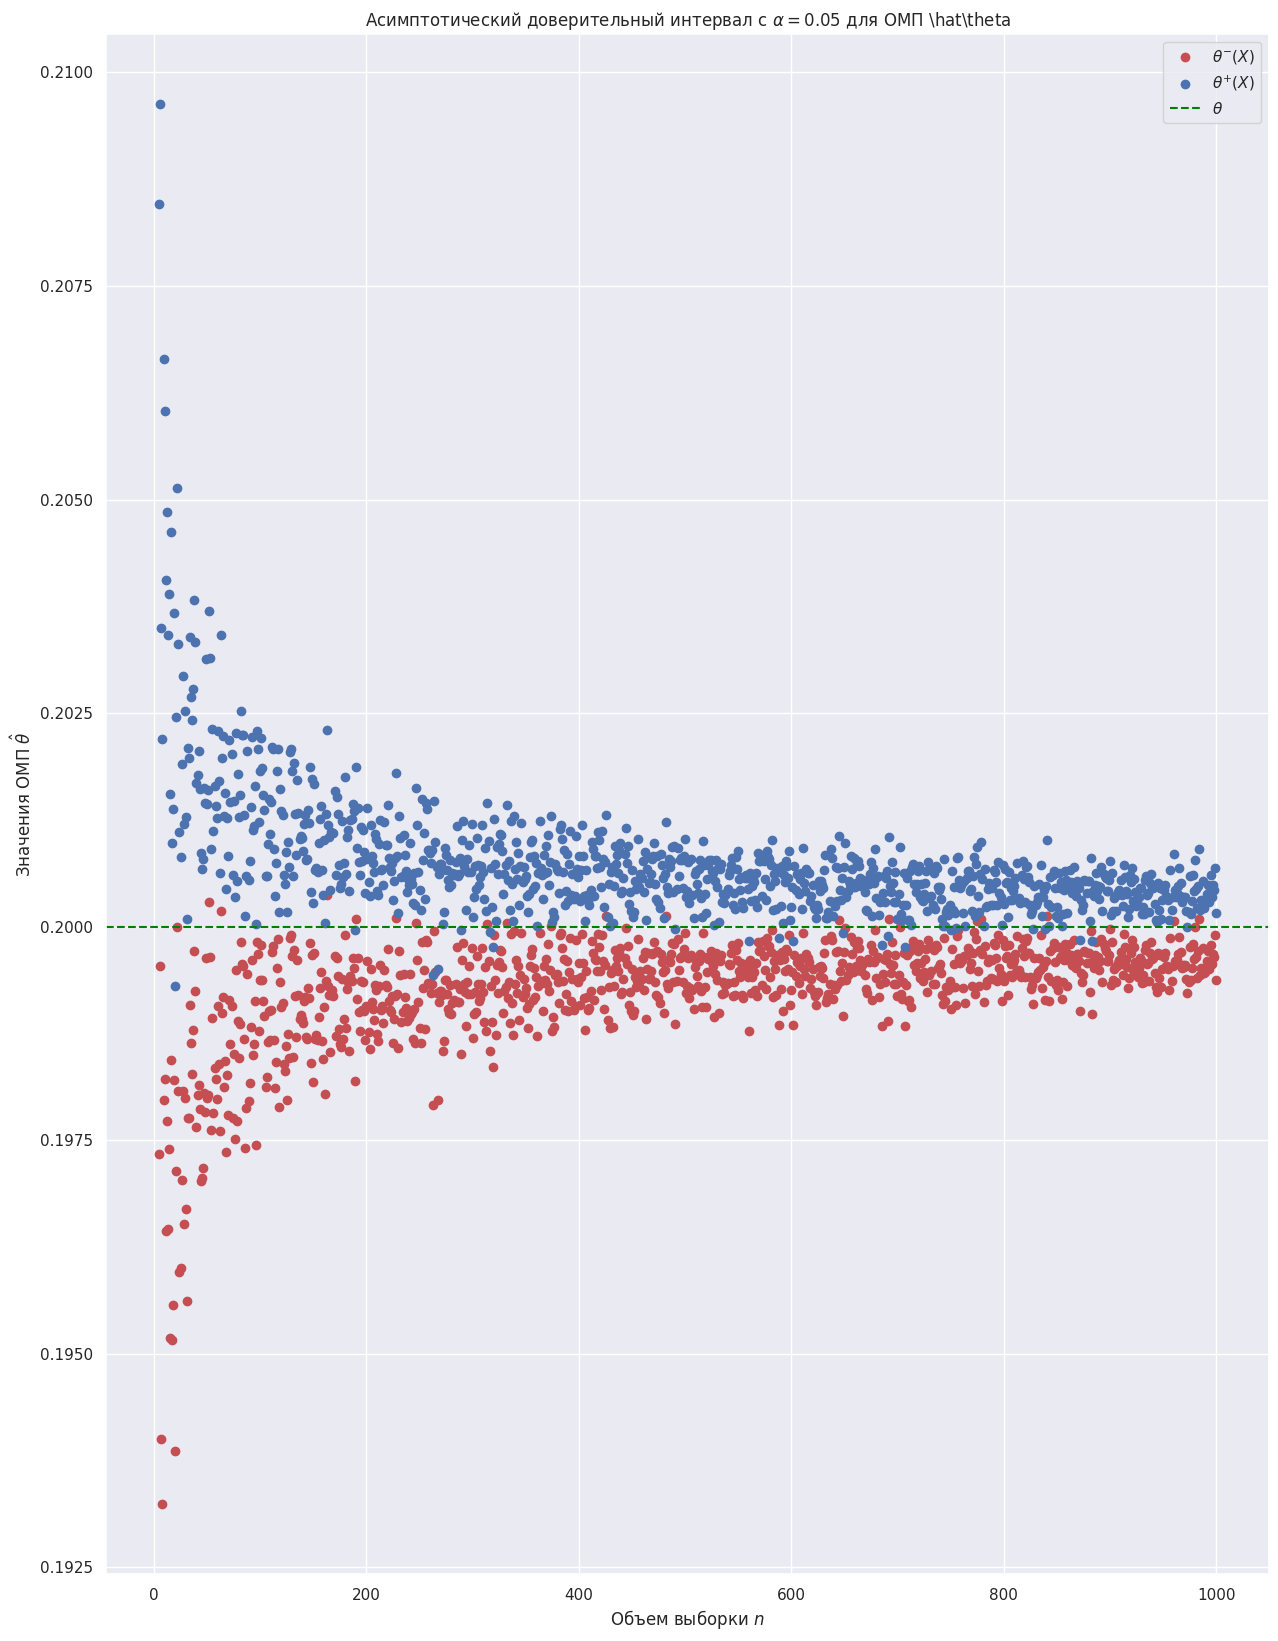

In [23]:
theta_minuses = []
theta_pluses = []
ci_range = range(5, 1000 + 1)

for i in ci_range:
  samples = binom.rvs(size=(num_of_samples, i))
  theta_hat = samples.mean(axis=1) / m

  theta_mean = theta_hat.mean()
  theta_var = theta_hat.var()
  theta_minus = theta_mean - tau * np.sqrt(theta_var / num_of_samples)
  theta_minuses.append(theta_minus)
  theta_plus = theta_mean + tau * np.sqrt(theta_var / num_of_samples)
  theta_pluses.append(theta_plus)


plt.figure(figsize=(15, 20))
plt.scatter(ci_range, theta_minuses, c="r", label=r"$\theta^{-}(X)$")
plt.scatter(ci_range, theta_pluses, c="b", label=r"$\theta^{+}(X)$")
plt.axhline(theta, c="green", linestyle="dashed", label=r"$\theta$")
plt.xlabel("Объем выборки " + r"$n$")
plt.ylabel("Значения ОМП " + r"$\hat\theta$")
plt.title("Асимптотический доверительный интервал с " + rf"$\alpha={threshold}$ " + "для ОМП " + r"\hat\theta")
plt.legend()
plt.show()




По графику видно, что истинное значение параметра $\theta$ чаще всего попадает в доверительный интервал $(\theta^{-}(X), \theta^{+}(X))$, а также доверительный интервал с увеличением размера выборки $n$ суживается вокруг истинного значения параметра (доверительный интервал получился асимптотическим)

### Задание 2

Обозначим за $R(\hat\theta, \theta)$ некоторую функцию потерь, обозначающую, насколько вычисленное значение параметра отличается от истинного. Оценка параметра будет эффективной, когда она минимизирует в среднем функцию потерь, то есть $\overline{R}(\hat\theta, \theta)=E\{R(\hat\theta, \theta)\}=\int_{-\infty}^{+\infty}\ldots \int_{-\infty}^{+\infty}R(\hat\theta, \theta)f(\theta, X)d\theta dx_1 dx_2 \ldots dx_n=\int_{-\infty}^{+\infty}\ldots \int_{-\infty}^{+\infty}R(\hat\theta, \theta)f(\theta | X)f(\overline{x})d\theta dx_1 dx_2 \ldots dx_n$.

Достаточно минимизировать выражение $R(X)=\int_{-\infty}^{+\infty}R(\hat\theta, \theta)f(\theta|X)d\theta$, так как только оно зависит от $\theta$. Тогда $\hat\theta = argmin \ \int_{-\infty}^{+\infty}R(\hat\theta, \theta)f(\theta|X)d\theta$

По условию функция потерь имеет вид $R(\hat\theta, \theta)=(\hat\theta - \theta)^2$, тогда найдем точку минимума: $\frac{d}{d\theta}\int_{-\infty}^{+\infty}(\hat\theta - \theta)^2f(\theta|X)d\theta = 0 \Leftrightarrow \int_{-\infty}^{+\infty}\hat\theta f(\theta|X)d\theta - \int_{-\infty}^{+\infty}\theta f(\theta | X)d\theta \Leftrightarrow \hat \theta = \int_{-\infty}^{+\infty}\theta f(\theta | X) d\theta=E[\theta | X]$

По условию $\theta$ ~ $Be(a, b)$, $X$ ~ $Geom(\theta)$ ($a, b > 0$, $0<\theta<1$). Надо определить апостериорное распределение $\theta | X$

$f(\theta | X) = f(X | \theta) f(\theta) = L(\theta) f(\theta)$

$L(\theta)=\Pi_{j=1}^{n}\theta (1-\theta)^{x_j}=\theta^{n}(1-\theta)^{\sum_{j=1}^{n}x_j}$

$f(\theta | X) = L(\theta) f(\theta) = \theta^{n}(1-\theta)^{\sum_{j=1}^{n}x_j} \cdot \frac{\theta^{a - 1}(1-\theta)^{b-1}}{B(a, b)}=\frac{1}{B(a, b)}\theta^{a+n - 1}(1-\theta)^{b-1+\sum_{j=1}^{n}x_j} \propto \theta^{a+n - 1}(1-\theta)^{b-1+\sum_{j=1}^{n}x_j}$, следовательно, $\theta | X$ ~ $Be(a+n, b + \sum_{j=1}^{n}x_j)$  (на $B(a, b)$ мы можем закрыть глаза, так как оно не зависит от $\theta$ и не влияет на форму распределения и его матожидание)

Итого $\hat\theta = E[\theta | X] = \frac{a+n}{a+n+b+\sum_{j=1}^{n}x_j}$

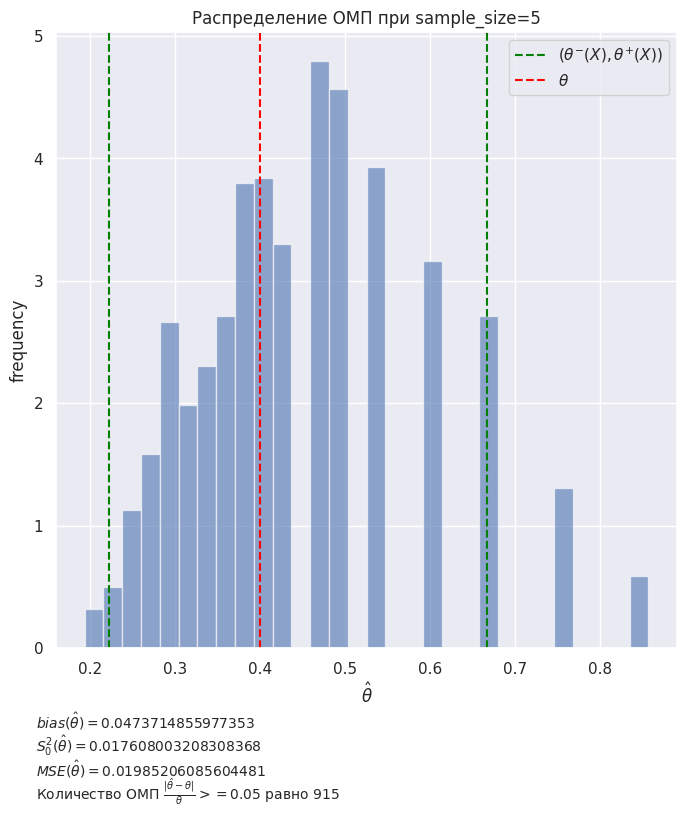

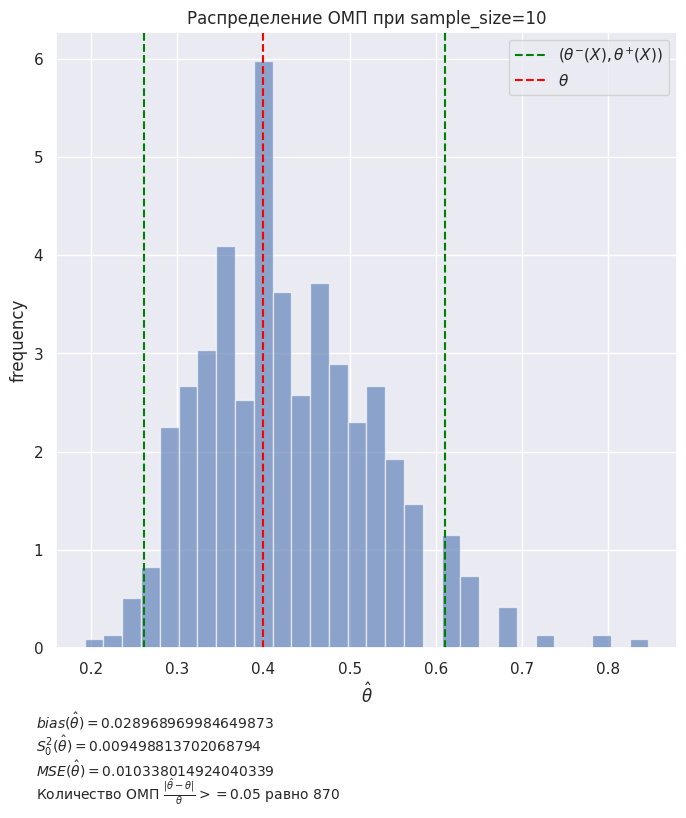

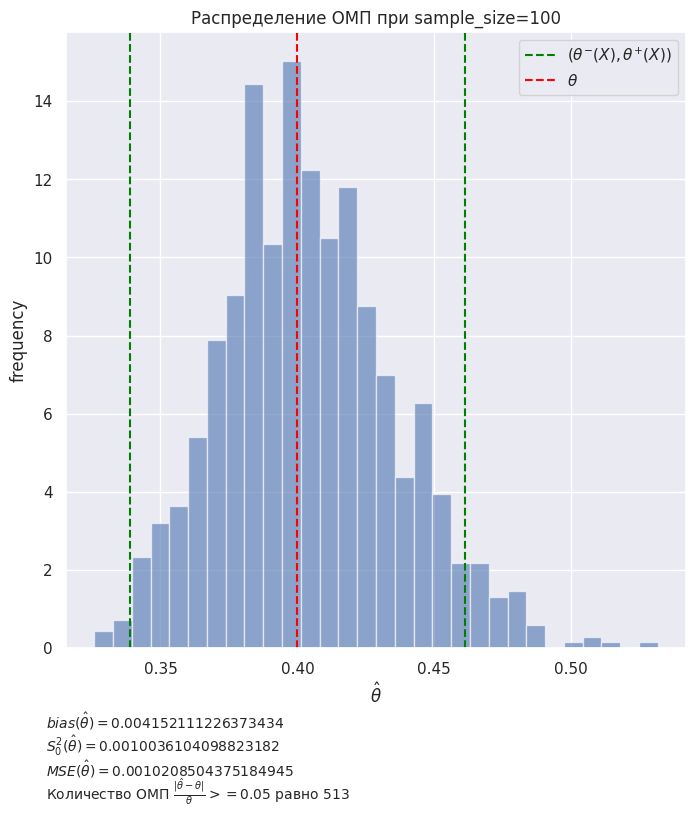

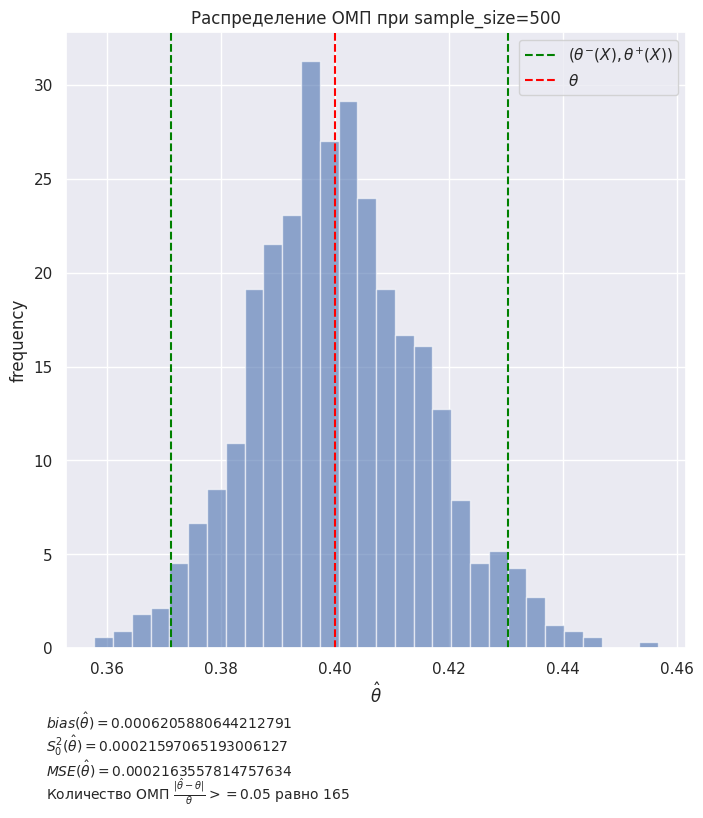

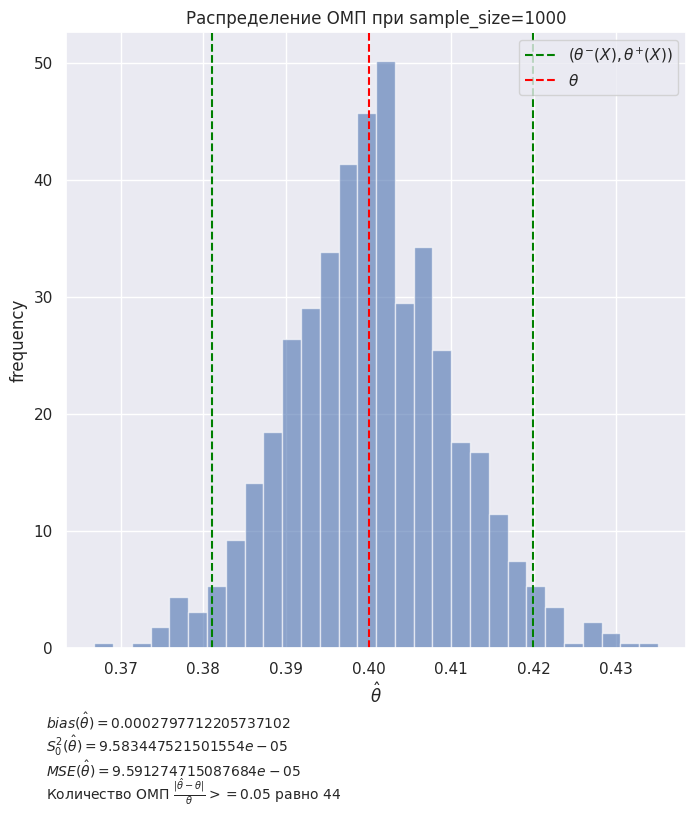

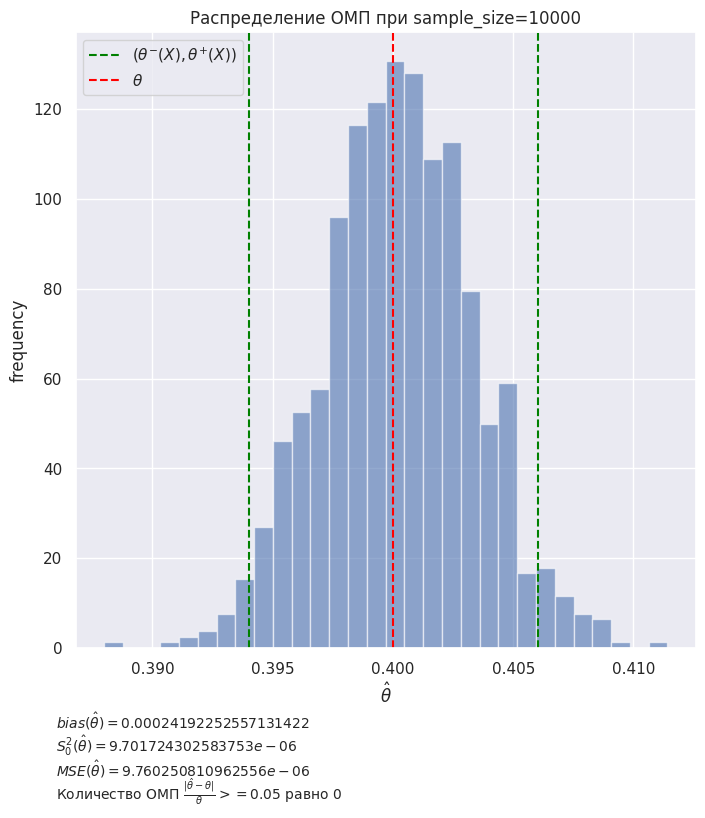

In [69]:
sample_sizes = [5, 10, 100, 500, 1000, 10000]
num_of_samples = 1000

a = b = 1
theta = 0.4
geom = stats.geom(theta, loc=-1)

for sample_size in sample_sizes:
  samples = geom.rvs(size=(num_of_samples, sample_size))
  theta_hat = (a + sample_size) / (a + sample_size + b + samples.sum(axis=1))
  plot_theta_extimates(theta_hat, theta, sample_size, interval_type="credible")


Поскольку Бета-распределение в общем случае не является симметричным, используем здесь не доверительный интервал, а достоверный интервал (который чаще всего и используется при байесовском подходе). Основное отличие: доверительнй интервал с уровнем доверия 95% значит, что 95% интервалов накроют истинное значение параметра; достоверный интервал с уровнем доверия 95% значит, что с вероятностью 95% истинное значение параметра находится в этом интервале.

У достоверного интервала есть разные методы построения, здесь использован HDI, то есть построение минимального интервала, который с заданной вероятностью содержит истинное значение параметра. Из-за формулировки достоверный интервал "шире" доверительного, однако при увеличении $n$ он так же сужается вокруг истинного значения параметра.

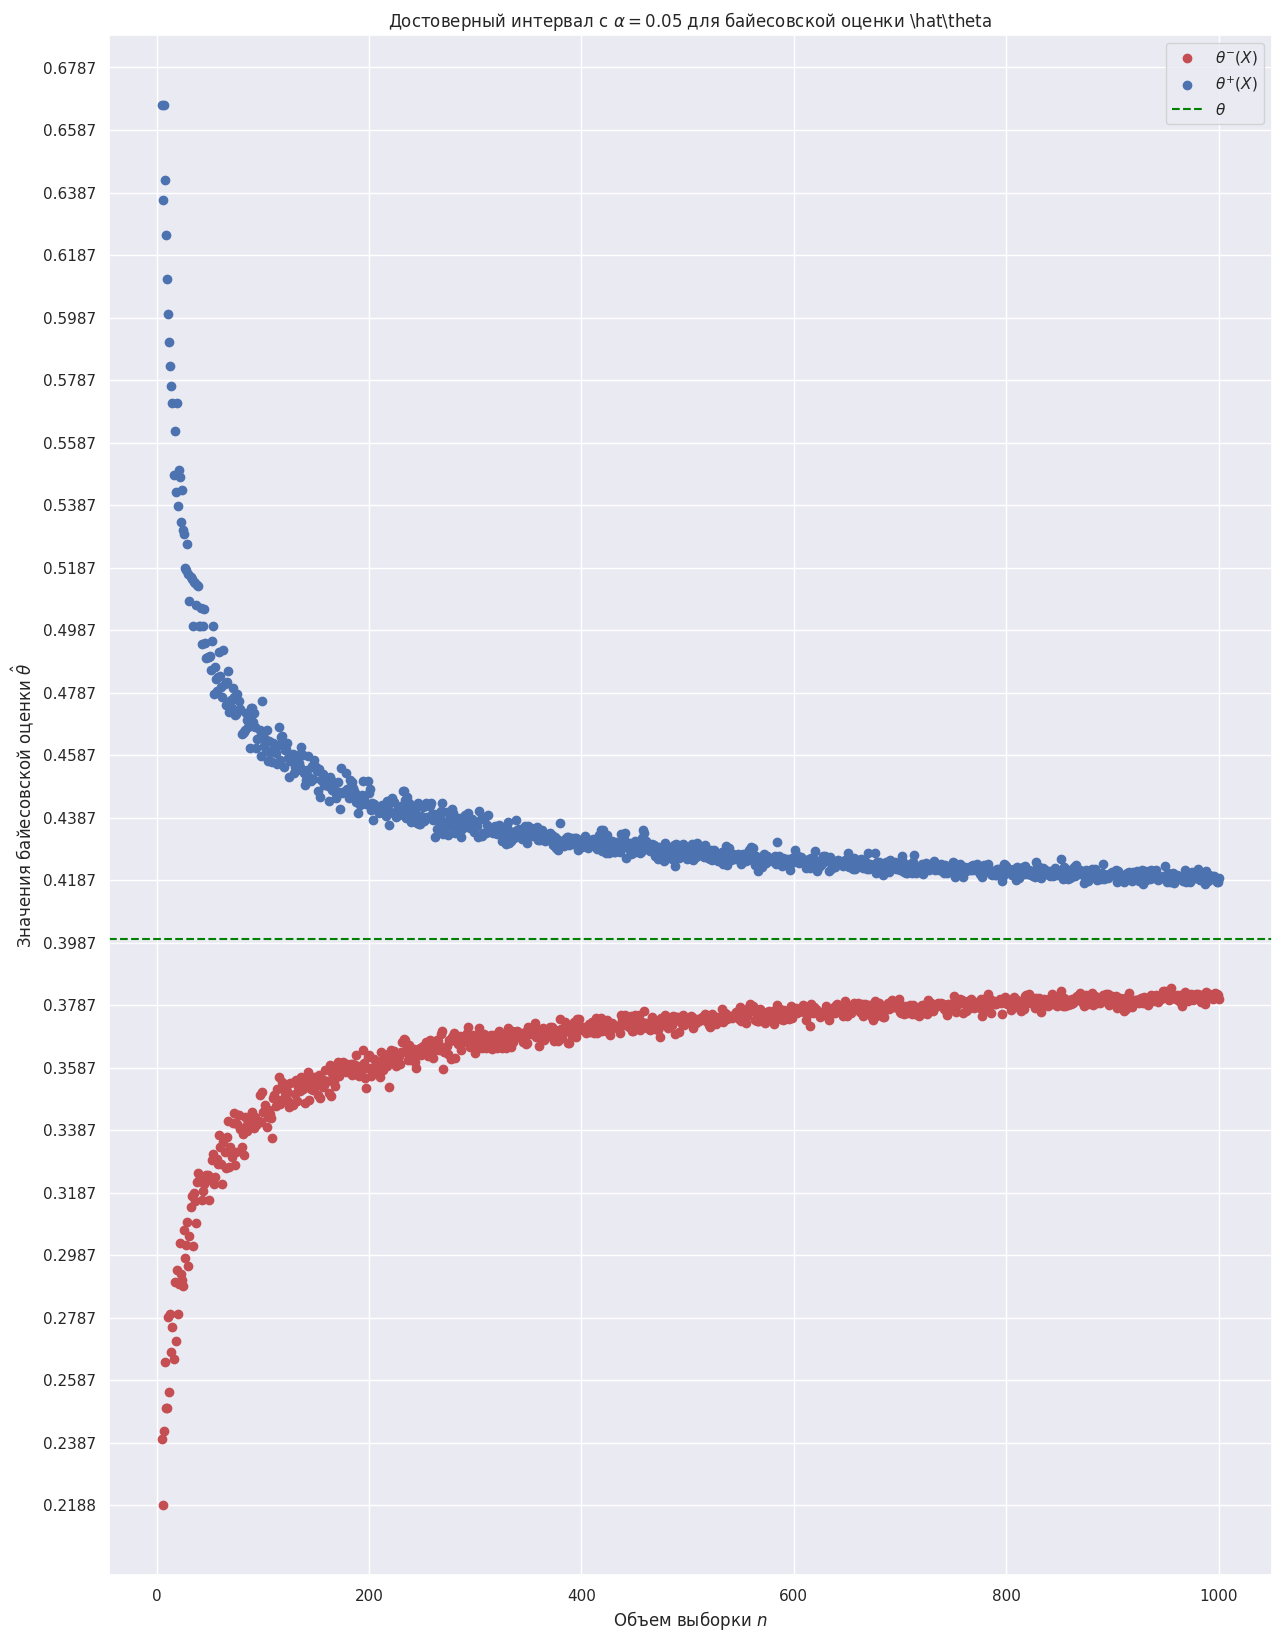

In [74]:
theta_minuses = []
theta_pluses = []
ci_range = range(5, 1000 + 1)

for i in ci_range:
  samples = geom.rvs(size=(num_of_samples, i))
  theta_hat = (a + i) / (a + i + b + samples.sum(axis=1))

  theta_minus, theta_plus = theta_minus, theta_plus = arviz.hdi(theta_hat, hdi_prob=1 - threshold)
  theta_minuses.append(theta_minus)
  theta_pluses.append(theta_plus)


plt.figure(figsize=(15, 20))
plt.scatter(ci_range, theta_minuses, c="r", label=r"$\theta^{-}(X)$")
plt.scatter(ci_range, theta_pluses, c="b", label=r"$\theta^{+}(X)$")
plt.axhline(theta, c="green", linestyle="dashed", label=r"$\theta$")
plt.yticks(np.arange(min(theta_minuses), max(theta_pluses) + 0.02, 0.02))
plt.xlabel("Объем выборки " + r"$n$")
plt.ylabel("Значения байесовской оценки " + r"$\hat\theta$")
plt.title("Достоверный интервал с " + rf"$\alpha={threshold}$ " + "для байесовской оценки " + r"\hat\theta")
plt.legend()
plt.show()


